# Python Parallel Computing
Part of this lecture is based on the material by [Dr. Gregory Watson](https://nyu-cds.github.io/python-itertools/)

Lets start with the introductory text by Dr.Gregory Watson about [parallel computing](https://nyu-cds.github.io/python-mpi/01-introduction/).

You need to install:
- open-mpi (brew install open-mpi)
- mpi4py (pip3 install mpi4py)

A more detailed description this [page](https://info.gwdg.de/~ceulig/docs-dev/doku.php?id=en:services:application_services:high_performance_computing:mpi4py) for a more detailed discussion of mpi4py.

---
The most commonly used method of programming distributed-memory multiple instruction, multiple data (MIMD) systems is message passing, being __MPI__ the most widely used standard.

Processes should coordinate their activities by explicitly sending and receiving messages, a mechanism known as __point to point communication__.

MPI operates as follows:
- Process A decides a message needs to be sent to process B.
- Process A packs up all of its necessary data into a buffer for process B.
- Process A indicates that the data should be sent to process B by calling the _Send_ function.
- Process B needs to acknowledge it wants to receive the message by calling the _Recv_ function.

Every time a process sends a message, there must be a process that also indicates it wants to receive the message, therefore, calls to _Send_ and _Recv_ are always paired.

The number of processes is fixed when an MPI program is started and each of the processes is assigned a unique integer starting from 0. This integer is know as the rank of the process and is how each process is identified when sending and receiving messages (we will refer to rank K process as "process K").

MPI processes are arranged in logical collections known as communicators. There is one special communicator that exists when an MPI program starts, which contains all the processes in the MPI program. This communicator is called MPI.COMM_WORLD. In mpi4py, communicators are represented by the __Comm class__.

MPI provides a few methods on a communicator:
- Get_size() - returns the total number of processes contained in the communicator (the size of the communicator).
- Get_rank() - returns the rank of the calling process within the communicator. 
- Send() - sends content to a process
- Recv() - receives content from a process

In [3]:
#####
# I couldn't make mpi4pi work within jupyter notebook
#####

from mpi4py import MPI

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()
print('size=%d, rank=%d' % (size, rank))

size=1, rank=0


In [1]:
%%writefile mpi1.py
#####
# writting the code in the mpi1.py file
#####

from mpi4py import MPI

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()
print('size=%d, rank=%d' % (size, rank))

Overwriting mpi1.py


In [2]:
#####
# running MPI from the terminal
#####
!mpiexec -n 4 python3 mpi1.py

size=4, rank=2
size=4, rank=1
size=4, rank=3
size=4, rank=0


---
### One MPI program, multiple MPI processes
Making each process to perform a different computation 

In [9]:
%%writefile mpi2.py

from mpi4py import MPI
rank = MPI.COMM_WORLD.Get_rank()

a = 6.0
b = 3.0
if rank == 0:
        print(a + b)
if rank == 1:
        print(a * b)
if rank == 2:
        print(max(a,b))
if rank == 3:
        print('doing nothing')

Overwriting mpi2.py


In [10]:
!mpiexec -n 4 python3 mpi2.py

18.0
doing nothing
9.0
6.0


---
### Point-to-point communication
Message passing involves two processes: a sender and a receiver (commands _Send_ and _Recv_).

In [14]:
%%writefile mpi3.py
#####
# Sending a message from one process to another
#####

import numpy
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

randNum = numpy.zeros(1)

if rank == 1:
        randNum = numpy.random.random_sample(1)
        print("Process", rank, "drew the number", randNum[0])
        comm.Send(randNum, dest=0)

if rank == 0:
        print("Process", rank, "before receiving has the number", randNum[0])
        comm.Recv(randNum, source=1)
        print("Process", rank, "received the number", randNum[0])

Overwriting mpi3.py


In [15]:
!mpiexec -n 2 python3 mpi3.py

Process 1 drew the number 0.728416355067
Process 0 before receiving has the number 0.0
Process 0 received the number 0.728416355067


In [24]:
%%writefile mpi4.py
#####
# Sending a message to a process and receiving a message back
#####

import numpy
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

randNum = numpy.zeros(1)

if rank == 1:
        randNum = numpy.random.random_sample(1)
        print("Process", rank, "drew the number", randNum[0])
        comm.Send(randNum, dest=0)
        comm.Recv(randNum, source=0)
        print("Process", rank, "received the number", randNum[0], "from process 0")
        
if rank == 0:
        print("Process", rank, "before receiving has the number", randNum[0])
        comm.Recv(randNum, source=1)
        print("Process", rank, "received the number", randNum[0], "from process 1")
        randNum *= 2
        comm.Send(randNum, dest=1) 

Overwriting mpi4.py


In [25]:
!mpiexec -n 2 python3 mpi4.py

Process 0 before receiving has the number 0.0
Process 1 drew the number 0.346582383384
Process 0 received the number 0.346582383384 from process 1
Process 1 received the number 0.693164766768 from process 0


The receiving process does not always need to specify the source when issuing a Recv. Instead, the process can accept any message that is being sent by another process. This is done by setting the source to MPI.ANY_SOURCE.

In [30]:
%%writefile mpi5.py
#####
# Sending a message to a process and receiving a message back from MPI.ANY_SOURCE
#####

import numpy
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

randNum = numpy.zeros(1)

if rank == 1:
        randNum = numpy.random.random_sample(1)
        print("Process", rank, "drew the number", randNum[0])
        comm.Send(randNum, dest=0)
        comm.Recv(randNum, source=MPI.ANY_SOURCE)
        print("Process", rank, "received the number", randNum[0], "from porcess", MPI.ANY_SOURCE)
        
if rank == 0:
        print("Process", rank, "before receiving has the number", randNum[0])
        comm.Recv(randNum, source=MPI.ANY_SOURCE)
        print("Process", rank, "received the number", randNum[0], "from porcess", MPI.ANY_SOURCE)
        randNum *= 2
        comm.Send(randNum, dest=1)

Overwriting mpi5.py


In [31]:
!mpiexec -n 2 python3 mpi5.py

Process 0 before receiving has the number 0.0
Process 1 drew the number 0.879768959584
Process 0 received the number 0.879768959584 from porcess -1
Process 1 received the number 1.75953791917 from porcess -1


Sometimes there are cases when a process might have to send many different types of messages to another process. Instead of having to go through extra measures to differentiate all these messages, MPI allows senders and receivers to also specify message IDs (known as tags) with the message. The receiving process can then request a message with a certain tag number and messages with different tags will be buffered until the process requests them.

```python
Comm.Send(buf, dest=0, tag=0)
Comm.Recv(buf, source=0, tag=0, status=None)
```

The _status_ can provide useful information
```python
info = MPI.Status()
source = info.Get_source()
tag = info.Get_tag()
count = info.Get_elements()
size = info.Get_count()
```

---
### Non-blocking Communication
In the previous examples, the sender and receiver are not able to perform any action when sending or receiving a message, wasting computational times while waiting for the call to complete. __Non-blocking communcation__ avoids this issue by using the _Isend_ and _Irecv_ methods, which start to send and receive operations and then return immediately to continue computation.

The completion of a send or receive operation can be managed using the _Test_, _Wait_, and _Cancel_ methods.


In [1]:
%%writefile mpi6.py
#####
# this code is similar to mpi3.py, but it uses Wait to block the processes
#####

import numpy
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

randNum = numpy.zeros(1)

if rank == 1:
        randNum = numpy.random.random_sample(1)
        print("Process", rank, "drew the number", randNum[0])
        req = comm.Isend(randNum, dest=0)
        req.Wait()
        
if rank == 0:
        print("Process", rank, "before receiving has the number", randNum[0])
        req = comm.Irecv(randNum, source=1)
        req.Wait()
        print("Process", rank, "received the number", randNum[0])

Writing mpi6.py


In [2]:
!mpiexec -n 2 python3 mpi6.py

Process 0 before receiving has the number 0.0
Process 1 drew the number 0.691916965285
Process 0 received the number 0.691916965285


In [5]:
%%writefile mpi7.py
#####
# this code is similar to mpi3.py, but it uses Wait to block the processes
#####

import numpy
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

randNum = numpy.zeros(1) 

if rank == 1:
        randNum = numpy.random.random_sample(1)
        print("Process", rank, "drew the number", randNum[0])
        comm.Isend(randNum, dest=0)
        randNum[0] /= 3.14 # overlap communication
        print("Process", rank, "number in overlap communication =", randNum[0])
        req = comm.Irecv(randNum, source=0)
        req.Wait()
        print("Process", rank, "received the number", randNum[0])

if rank == 0:
        print("Process", rank, "before receiving has the number", randNum[0])
        req = comm.Irecv(randNum, source=1)
        req.Wait()
        print("Process", rank, "received the number", randNum[0])
        randNum *= 2
        comm.Isend(randNum, dest=1)

Overwriting mpi7.py


In [6]:
!mpiexec -n 2 python3 mpi7.py

Process 0 before receiving has the number 0.0
Process 1 drew the number 0.743976553446
Process 1 number in overlap communication = 0.236935208104
Process 0 received the number 0.743976553446
Process 1 received the number 1.48795310689


---
### Problem Decomposition
A central problem when working with MPI is to break the problem into “chunks” to be handled by individual processes.

There are two main ways to decompose a problem: 
- __Domain decomposition:__ Data associated with a problem is split into chunks and each parallel process works on a chunk of the data.
- __Functional decomposition:__ Focus is on the computation rather than on the data. Used when pieces of data require different processing.

#### Example of a domain decompostion with MPI

Hermite interpolation:
<img src="img8.png" alt="Drawing" style="width: 300px;"/>
$$
p(t)=ax^3+bx^2+cx+d\Longrightarrow
\begin{array}{l}
ax_0^3+bx_0^2+cx_0+d = y_0\\
ax_1^3+bx_1^2+cx_1+d = y_1\\
3ax_0^2+2bx_0+c = m_0\\
3ax_1^2+2bx_1+c = m_1
\end{array}
\Longrightarrow
\left[\begin{array}{cccc}
x_0^3 & x_0^2 & x_0 & 1\\
x_1^3 & x_1^2 & x_1 & 1\\
3x_0^2 & 2x_0 & 1 & 0\\
3x_1^2 & 2x_1 & 1 & 0
\end{array}\right]
\left[\begin{array}{c}
a\\
b\\
c\\
d
\end{array}\right]=
\left[\begin{array}{c}
y_0\\
y_1\\
m_0\\
m_1
\end{array}\right]
$$

In [30]:
def hermite(data):
    A = np.zeros((4,4))
    pts = []
    for i in range(data.shape[0]):
        A[0:2]=np.array([np.power(data[i,0:2],3),np.power(data[i,0:2],2),data[i,0:2],np.array([1,1])]).T
        A[2:4]=np.array([3*np.power(data[i,0:2],2),2*data[i,0:2],np.array([1,1]),np.array([0,0])]).T
        b = data[i,2:]
        coefs = np.linalg.solve(A,b)
        t = np.linspace(data[i,0],data[i,1],100)
        pts.extend(np.polyval(coefs,t))
    return(pts)

Took 0.08801794052124023s
99900


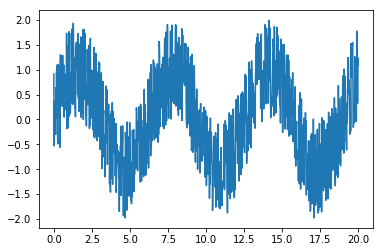

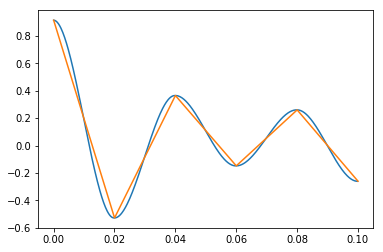

In [32]:
#####
# Finding the piece-wise hermite polynomial interpolation of a set of points
#####
from time import time
import numpy as np
import matplotlib.pyplot as plt


numx = 1000   # number of discretized points in x

x = np.linspace(0,20,numx)
y = np.random.uniform(low=-1,high=1,size=numx)+np.sin(x)
#y = np.exp(-np.power(x-500,2)/1e4)#+np.random.uniform(low=-0.1,high=0.1,size=numx)
#m = np.random.uniform(low=-1,high=1,size=numx)
m = np.zeros((numx,))
l = []

ts = time()
for i in range(numx-1):
    data = np.array([x[i],x[i+1],y[i],y[i+1],m[i],m[i+1]]).reshape(1,6)
    l.extend(hermite(data))
   
print('Took {}s'.format(time() - ts))
print(len(l))
s = np.linspace(0,20,len(l))
plt.figure(1)
plt.plot(s,l)
plt.figure(2)
plt.plot(s[0:500],l[0:500])
plt.plot(x[0:6],y[0:6])
plt.show()

In [ ]:
%%writefile mpi8.py
#####
# Finding the piece-wise hermite polynomial interpolation of a set of points
#####
from time import time
import numpy as np
import matplotlib.pyplot as plt
import numpy
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

l = []
ts = time()
for i in range(numx-1):
    data = np.array([x[i],x[i+1],y[i],y[i+1],m[i],m[i+1]]).reshape(1,6)
    
    l.extend(hermite(data))